In [56]:
import numpy as np

import sys
sys.path.insert(0, '../data_processing/')
import gcode_to_train as gtt

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [57]:
#filename = "../../data/gcode/hans_solo_blaster_fill_density_10.gcode"
#name = "hans_solo_blaster_fill_density_10"
name = "hexagon_slic3r"
filename = "../../data/gcode/" + name + ".gcode"
#filename = "../../data/gcode/square_base.gcode"
f = open(filename)
x = f.readlines()

In [64]:
start_ind = gtt.cut_header(x)
end_ind = gtt.cut_footer(x)
num_commands = end_ind - start_ind

training_data = np.zeros((num_commands, 6))
x_trimmed = x[start_ind: end_ind]

coordinates = gtt.gcode_to_training_data(x_trimmed, training_data)
# remove first 40 coordinates
coordinates = gtt.remove_starting_outline_points(coordinates)

coordinates_ext = gtt.augment_training_data(coordinates, delta=.1)

In [65]:
# limit to xyz
coordinates_ext = coordinates_ext[:,1:4]
# remove duplicates
coordinates_ext = gtt.remove_duplicates(coordinates_ext)

In [40]:
np.savetxt("../../data/point_cloud/" + name + "ext001"+ ".xyz", coordinates_ext)

In [ ]:
np.savetxt("../../data/point_cloud/" + name + ".xyz", coordinates)

In [66]:
first_plane = coordinates_ext[coordinates_ext[:,2]==0]

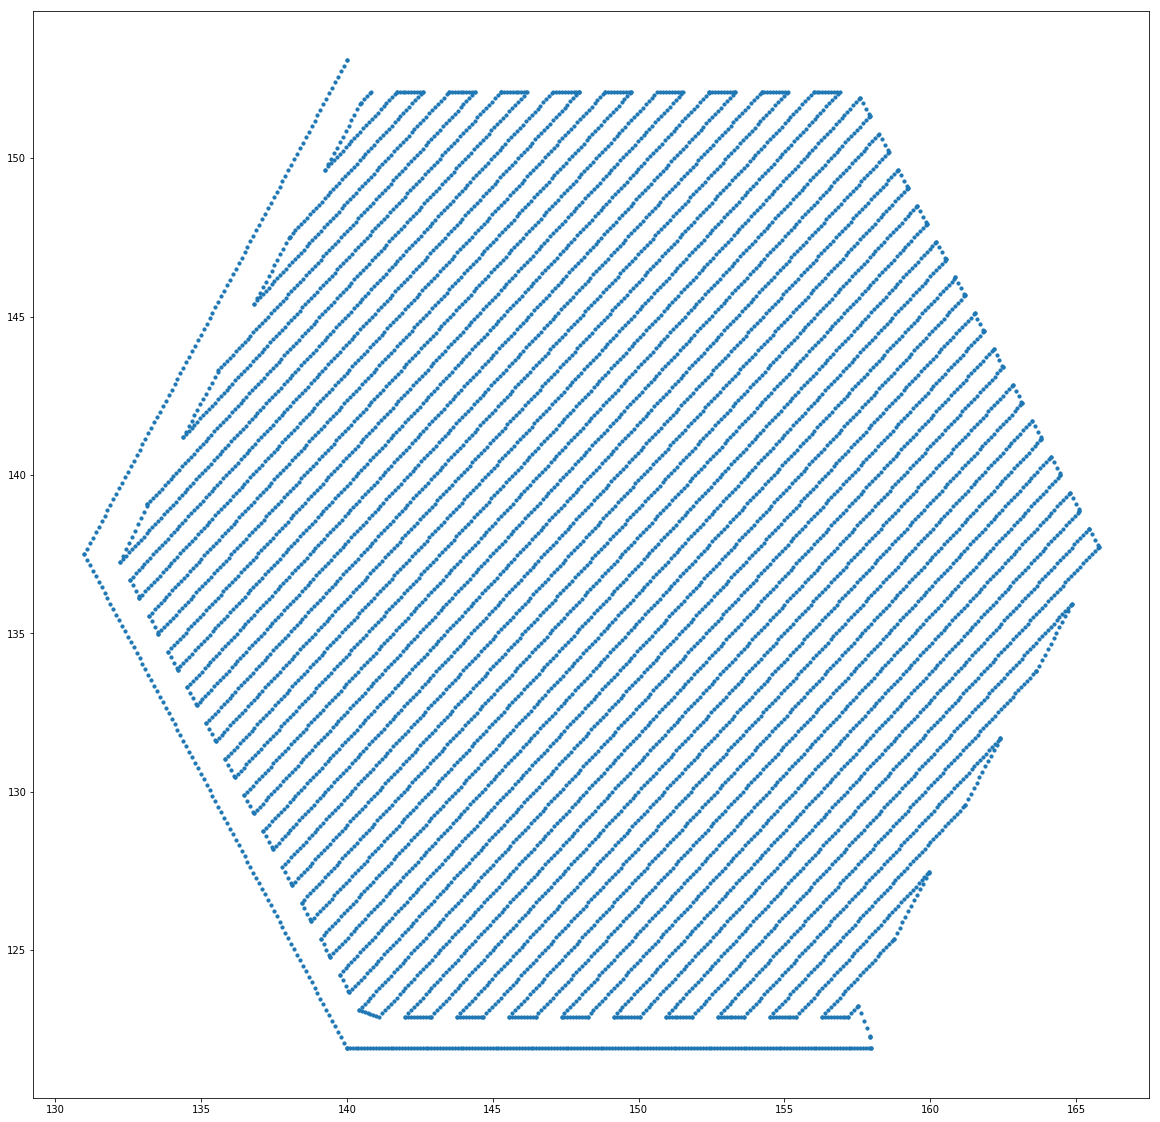

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.scatter(first_plane[:,0], first_plane[:,1], s=10.)

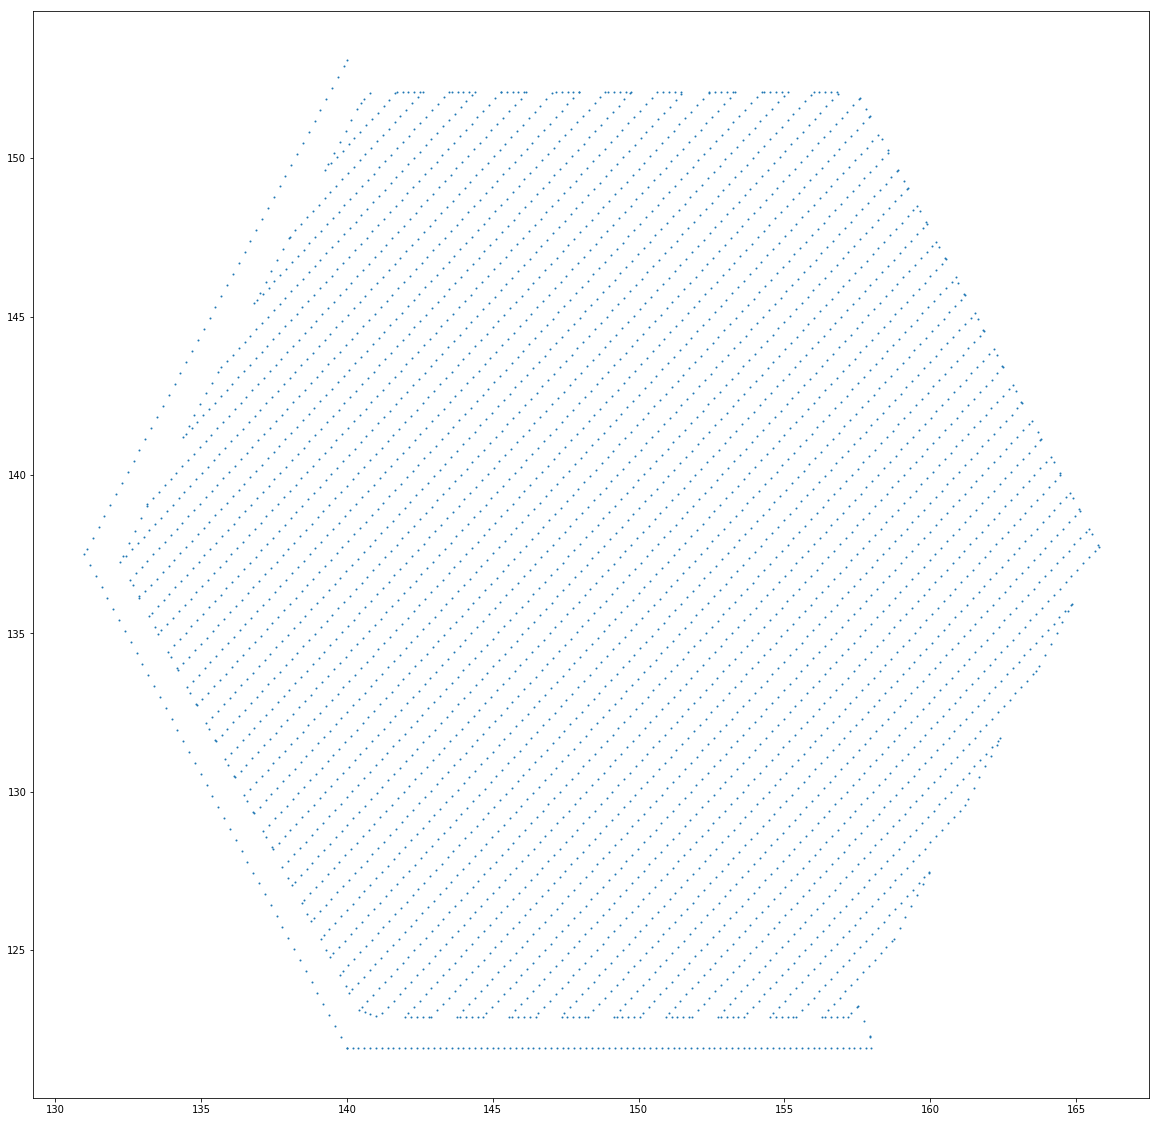

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.scatter(first_plane[::2,0], first_plane[::2,1], s=1.)

In [72]:
from scipy.spatial import Delaunay
tri = Delaunay(first_plane[::2])

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull d Qt Qbb Qz Qc Q12
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 1500821571  delaunay  Qtriangulate  Qbbound-last  Qz-infinity-point
  Qcoplanar-keep  Q12-no-wide-dup  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width 35  Error-roundoff 3.3e-13  _one-merge 3e-12
  Visible-distance 2e-12  U-coplanar-distance 2e-12  Width-outside 4e-12
  _wide-facet 1.2e-11

precision problems (corrected unless 'Q0' or an error)
      2 flipped facets
   4544 zero divisors during gaussian elimination

The input to qhull appears to be less than 4 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p4546(v4): 1.5e+02 1.4e+02     0    35
- p0(v3): 1.4e+02 1.5e+02     0    16
- p92(v2): 1.4e+02 1.2e+02     0     0
- p541(v1): 1.7e+02 1.4e+02     0    23
- p46(v0): 1.3e+02 1.4e+02     0   3.1

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 3.3e-13.  The center point, facets and distances
to the center point are as follows:

center point    145.1    137.5        0    15.41

facet p0 p92 p541 p46 distance=    0
facet p4546 p92 p541 p46 distance=    0
facet p4546 p0 p541 p46 distance=    0
facet p4546 p0 p92 p46 distance=    0
facet p4546 p0 p92 p541 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:       131     165.8  difference= 34.77
  1:     121.9     153.1  difference= 31.19
  2:         0         0  difference=    0
  3:         0     34.77  difference= 34.77

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 3.3e-13.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


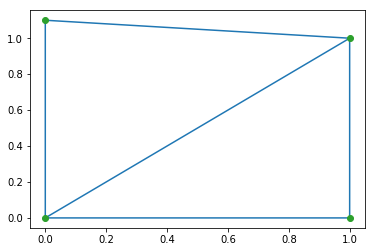

In [74]:
points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
tri = Delaunay(points)
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')


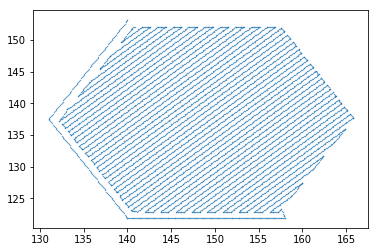

In [46]:
plt.scatter(first_plane[:,0], first_plane[:,1], s=.1)

In [ ]:
coordinates[0,:2], coordinates[1,:2]

In [ ]:
coordinates.shape, coordinates_ext.shape

In [ ]:
x = coordinates[0:2, 0]
y = coordinates[0:2, 1]
x,y

In [ ]:
A = np.vstack([x, np.ones(len(x))]).T

In [ ]:
m, c = np.linalg.lstsq(A, y, rcond=None)[0]

In [ ]:
def compute_linear_fit(x, y):
    '''
    given x and y compute linear fit
    return m (slope) and c (intercept)
    '''
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def f(x, m, c):
    '''linear function eval'''
    return m * x + c

def linear_interpolate(x, y, delta=0.1):
    '''
    interpolate points on a line with delta=.1
    preserves order and includes endpoints
    '''
    m, c = compute_linear_fit(x, y)
    x_interp = constant_interpolate(x, delta)  
    y_interp = f(x_interp, m, c)
    return x_interp, y_interp

def constant_interpolate(x, delta=0.1):
    start = np.min(x)
    end = np.max(x)
    x_interp = np.append(np.arange(start, end, delta), end)
    # reverse order
    if start != x[0]:
        x_interp = x_interp[::-1]
    # remove last element
    x_interp = x_interp[:-1]
    return x_interp

In [ ]:
interpolated_coordinates = []
delta = 0.5
for i in range(1, coordinates.shape[0]):
    # interpolate between points for same z-plane
    if coordinates[i-1,2] == coordinates[i, 2]:
        x, y = coordinates[i-1:i+1, 0], coordinates[i-1:i+1,1]
        isXUnique, isYUnique = len(np.unique(x)) == len(x), len(np.unique(y)) == len(y)
        # interpolate via linear fit
        if isXUnique and isYUnique: 
            x_interp, y_interp = linear_interpolate(x, y, delta)
        # interpolate with constant delta
        else:
            if isXUnique:
                x_interp = constant_interpolate(x, delta)
                y_interp = np.repeat(y[0], len(x_interp))
            else:
                y_interp = constant_interpolate(y, delta), 
                x_interp = np.repeat(x[0], len(y_interp))
        interpolated_coordinates.append(np.vstack([x_interp, y_interp, coordinates[i, 2] * np.ones(len(x_interp))]).T)
    # z-axis switches
    else:
        # append last point on previous plane
        interpolated_coordinates.append(coordinates[i-1])
# add last point
interpolated_coordinates.append(coordinates[-1])
interpolated_coordinates = np.vstack(interpolated_coordinates)

In [ ]:
from matplotlib.tri import Triangulation
from scipy.spatial import ConvexHull

# compute the convex hull of the points
X = coordinates
cvx = ConvexHull(X)

x, y, z = X[2:,0], X[2:,1], X[2:,2]

# cvx.simplices contains an (nfacets, 3) array specifying the indices of
# the vertices for each simplical facet
tri = Triangulation(x, y, triangles=cvx.simplices)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.hold(True)
ax.plot_trisurf(tri, z)
ax.plot_wireframe(x, y, z, color='r')
ax.scatter(x, y, z, color='r')

plt.draw()

In [ ]:
train_raw.shape

In [ ]:
tc = train_raw
tc = tc[~np.isnan(tc)].reshape(-1,6)

In [ ]:
tc[0:75,5]

In [ ]:
coordinates.shape

In [ ]:
coordinates.shape

In [ ]:
#%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(coordinates[0:40,0], coordinates[0:40,1], coordinates[0:40,2])
fig = plt.figure(figsize=(10,10))

In [ ]:
#%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(coordinates[2:,0], coordinates[2:,1], coordinates[2:,2], s=.1)
fig = plt.figure(figsize=(100,100))

In [ ]:
ax.scatter3D(coordinates[:,0], coordinates[:,1], coordinates[:,2])

In [ ]:
coordinates